In [1]:
!nvidia-smi

Sun Apr 13 06:26:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!apt-get update
!apt-get install -y libopencv-dev python3-opencv pkg-config
!nvcc --version

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,099 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,542 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packag

In [3]:
!pkg-config --cflags --libs opencv4

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [6]:
# Step 1: Write CUDA code to a file
code = r'''
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

#define BLUR_SIZE 1

// Kernel for grayscale blur
__global__ void blurKernel(unsigned char* image, unsigned char* blurred, unsigned int width, unsigned int height) {
    int outRow = blockIdx.y * blockDim.y + threadIdx.y;
    int outCol = blockIdx.x * blockDim.x + threadIdx.x;

    if (outRow < height && outCol < width) {
        int average = 0;
        int count = 0;
        for (int inRow = outRow - BLUR_SIZE; inRow <= outRow + BLUR_SIZE; ++inRow) {
            for (int inCol = outCol - BLUR_SIZE; inCol <= outCol + BLUR_SIZE; ++inCol) {
                if (inRow >= 0 && inRow < height && inCol >= 0 && inCol < width) {
                    average += image[inRow * width + inCol];
                    count++;
                }
            }
        }
        blurred[outRow * width + outCol] = average / count;
    }
}

// GPU blur function
void blurGPU(unsigned char* image_H, unsigned char* blurred_H, unsigned int width, unsigned int height) {
    unsigned char *image_D, *blurred_D;
    size_t size = width * height * sizeof(unsigned char);

    cudaMalloc((void**)&image_D, size);
    cudaMalloc((void**)&blurred_D, size);

    cudaMemcpy(image_D, image_H, size, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (height + threadsPerBlock.y - 1) / threadsPerBlock.y);

    blurKernel<<<numBlocks, threadsPerBlock>>>(image_D, blurred_D, width, height);
    cudaDeviceSynchronize();

    cudaMemcpy(blurred_H, blurred_D, size, cudaMemcpyDeviceToHost);

    cudaFree(image_D);
    cudaFree(blurred_D);
}

int main() {
    // Load grayscale image
    cv::Mat image = cv::imread("input.jpg", cv::IMREAD_GRAYSCALE);
    if (image.empty()) {
        std::cerr << "Error loading image!" << std::endl;
        return -1;
    }

    int width = image.cols;
    int height = image.rows;

    unsigned char* input = image.data;
    unsigned char* output = new unsigned char[width * height];

    // Time the GPU blur
    auto start = std::chrono::high_resolution_clock::now();
    blurGPU(input, output, width, height);
    auto end = std::chrono::high_resolution_clock::now();
    float elapsed = std::chrono::duration<float, std::milli>(end - start).count();

    std::cout << "Blur on GPU took " << elapsed << " ms\n";

    // Save output image
    cv::Mat blurredImage(height, width, CV_8UC1, output);
    cv::imwrite("blurred_output.jpg", blurredImage);

    delete[] output;
    return 0;
}



'''

# Step 2: Save to file
with open('script.cu', 'w') as f:
    f.write(code)

# Step 3: Compile using nvcc
# Ref: https://stackoverflow.com/questions/73361454/i-am-getting-zeros-as-a-result-of-vector-additon-in-cuda-and-no-errors
!nvcc -arch=sm_75 script.cu -o script `pkg-config --cflags --libs opencv4`

# Step 4: Run the binary
!./script


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

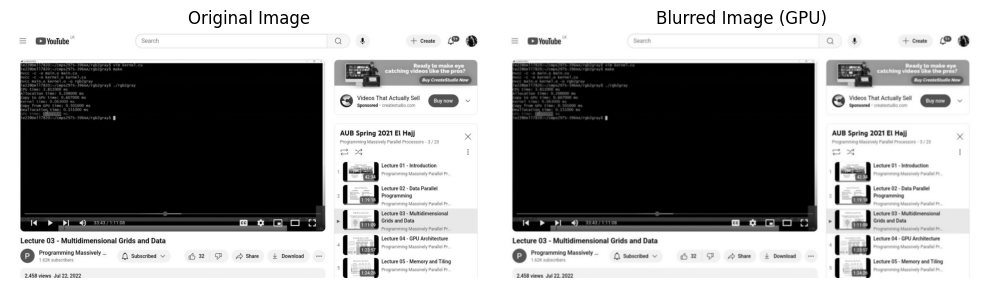

In [10]:
import cv2
from matplotlib import pyplot as plt

# Load images
original = cv2.imread("input.jpg", cv2.IMREAD_GRAYSCALE)
blurred = cv2.imread("blurred_output.jpg", cv2.IMREAD_GRAYSCALE)

# Display side by side
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blurred Image (GPU)")
plt.imshow(blurred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
